#  Illinois Income and Education Status vs Gun Violence Data
We will be taking a look at the geogrpahic location of gun violence incidents and over laying them with a chlorepleth map of Illinois income and education census tracts. By doing this we can see if there is a correlation to where gun violence incidents occur and where income/education is lower/higher.

We will now install the libraries needed to read/wrangle data, create spacial data, and overlay maps

In [1]:
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

import osmnx as ox
import pandas as pd

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Illinois Education Comparison

We will be importing our first sets of data which is the Illinois census tracts

In [2]:
illinoisInc = gpd.read_file('acs2019_5yr_B19001_05000US17181.geojson')
illinoisEdu = gpd.read_file('acs2019_5yr_B15002_05000US17021.geojson')
illinoisInc.head()

,geoid,name,B19001001,"B19001001, Error",B19001002,"B19001002, Error",B19001003,"B19001003, Error",B19001004,"B19001004, Error",...,"B19001013, Error",B19001014,"B19001014, Error",B19001015,"B19001015, Error",B19001016,"B19001016, Error",B19001017,"B19001017, Error",geometry
0,01000US,United States,120756048.0,236892.0,7302871.0,18046.0,5189583.0,15224.0,5300624.0,15337.0,...,51444.0,11019036.0,49867.0,7267775.0,40108.0,8173563.0,49077.0,9264390.0,54033.0,"MULTIPOLYGON (((-168.22527 -14.53591, -168.199..."
1,04000US17,Illinois,4846134.0,10459.0,302966.0,3949.0,185043.0,2873.0,202275.0,3027.0,...,4983.0,464761.0,4697.0,313318.0,3840.0,360394.0,3979.0,401583.0,4359.0,"MULTIPOLYGON (((-91.18529 40.63780, -91.17510 ..."
2,05000US17001,"Adams County, IL",27112.0,358.0,1547.0,262.0,881.0,182.0,1692.0,263.0,...,326.0,2219.0,250.0,1203.0,210.0,1093.0,174.0,992.0,198.0,"MULTIPOLYGON (((-91.42411 39.93575, -91.42464 ..."
3,05000US17003,"Alexander County, IL",2154.0,161.0,240.0,70.0,169.0,63.0,149.0,53.0,...,60.0,52.0,31.0,44.0,27.0,56.0,36.0,9.0,11.0,"MULTIPOLYGON (((-89.19975 37.08887, -89.19963 ..."
4,05000US17005,"Bond County, IL",6299.0,360.0,467.0,145.0,277.0,116.0,358.0,133.0,...,176.0,634.0,144.0,306.0,85.0,280.0,85.0,207.0,81.0,"MULTIPOLYGON (((-89.36179 39.02772, -89.35987 ..."


we will clean the data by removing the first two outliers, the US data and the overall state of Illinois data

In [3]:
illinoisEdu = illinoisEdu.drop([0])
illinoisEdu = illinoisEdu.drop([1])

Trim down the columns

In [4]:
list(illinoisEdu)
columns_to_keep = ['geoid',
'name',
'B15002001',
'B15002011',
'B15002015',
'B15002028',
'B15002032',
'geometry']
illinoisEdu = illinoisEdu[columns_to_keep]

Rename the columns so they are usable and check to see if altered correctly

In [5]:
illinoisEdu.columns= ['geoid',
'name',
'Total',
'males with HS degree',
'males with BA degree',
'females with HS degree',
'females with BA degree',
'geometry']
illinoisEdu.head()

,geoid,name,Total,males with HS degree,males with BA degree,females with HS degree,females with BA degree,geometry
2,05000US17001,"Adams County, IL",46125.0,8333.0,3483.0,8002.0,3851.0,"MULTIPOLYGON (((-91.42411 39.93575, -91.42464 ..."
3,05000US17003,"Alexander County, IL",4497.0,858.0,211.0,974.0,236.0,"MULTIPOLYGON (((-89.19975 37.08887, -89.19963 ..."
4,05000US17005,"Bond County, IL",11741.0,2207.0,741.0,1681.0,901.0,"MULTIPOLYGON (((-89.36179 39.02772, -89.35987 ..."
5,05000US17007,"Boone County, IL",35008.0,6113.0,2168.0,6079.0,2855.0,"MULTIPOLYGON (((-88.94075 42.41387, -88.94074 ..."
6,05000US17009,"Brown County, IL",4863.0,1262.0,242.0,563.0,258.0,"MULTIPOLYGON (((-90.91469 40.01804, -90.91469 ..."



Now I will normalize the raw data and add colums to my data that give %’s of each education level

In [6]:
illinoisEdu['percent males with HS degree'] = illinoisEdu['males with HS degree']/illinoisEdu['Total']*100
illinoisEdu['percent males with BA degree'] = illinoisEdu['males with BA degree']/illinoisEdu['Total']*100
illinoisEdu['percent females with HS degree'] = illinoisEdu['females with HS degree']/illinoisEdu['Total']*100
illinoisEdu['percent females with BA degree'] = illinoisEdu['females with BA degree']/illinoisEdu['Total']*100


we will combine all the levels of education to get a total amount of people educated

In [7]:
illinoisEdu['total educated'] = illinoisEdu['males with HS degree']+illinoisEdu['males with BA degree']+illinoisEdu['females with HS degree']+illinoisEdu['females with BA degree']

now we will get the percent of total per census tract

In [8]:
illinoisEdu['percent total educated'] = illinoisEdu['total educated']/illinoisEdu['Total']*100

show the census tract groups in illinois using black lines

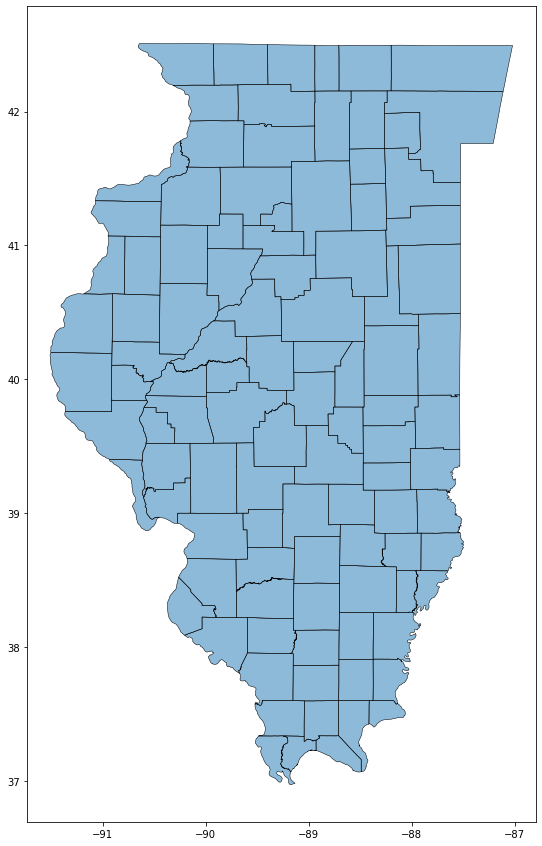

In [9]:
fig,ax = plt.subplots(figsize=(15,15))
illinoisEdu.plot(ax=ax,zorder=10,alpha=.5)
illinoisEdu.boundary.plot(ax=ax,color='black',zorder=15,lw=0.5)

we will now projecrt onto a mercator map

In [10]:
illinoisEdu =illinoisEdu.to_crs(epsg=3857)

plot. turn off the axis, and add a base map

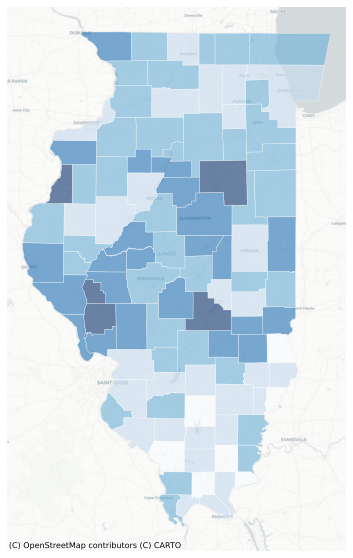

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

illinoisEdu.plot(column='percent total educated', 
            cmap= 'Blues', 
            scheme='equal_interval',
            k=5, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.6, 
            ax=ax
           )
ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Illinois Income vs Gun Violence Incidents
we will now compare the gun violence incidents as a scatterplot map to the chloropleth income map

import the gun violence data

In [12]:
gvIllinois = gpd.read_file('cleanGunDataIllinois.csv')


clean the data so we only have the geospatial aspect

In [13]:
gvIllinois  = gvIllinois [[
 'latitude',
 'longitude']]
gvIllinois 

,latitude,longitude
0,41.7592,-87.5628
1,41.7358,-87.6631
2,41.7906,-87.6418
3,39.5417,-90.3301
4,41.8968,-87.7556
...,...,...
17551,42.2523,-89.0864
17552,,
17553,,
17554,41.7286,-87.6425


convert the string type data to usable float data

In [14]:
gvIllinois ['latitude'] = pd.to_numeric(gvIllinois ['latitude'],errors='coerce')
gvIllinois ['longitude'] = pd.to_numeric(gvIllinois ['longitude'],errors='coerce')

convert from pandas to geopandas dataframe

In [15]:
gvIllinois  = gpd.GeoDataFrame(gvIllinois , 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(gvIllinois.longitude, gvIllinois.latitude))

projec the data onto a mercator map

In [16]:
gvIllinois  = gvIllinois .to_crs(epsg=3857)

now apply the bounds of Illinois

In [17]:
minx, miny, maxx, maxy = illinoisEdu.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-10187189.355204618
-9687014.853063764
4434967.519736574
5237454.393795698


now we set up a plot canvas using plt.subplots. we plot the Illinois income census tract and texas gun violence data. we use the bounding box coodinates from earlier to set the x and y limits and add an agrument to create a margin around the total bounds. finally, no axis and add chloropleth basemap.



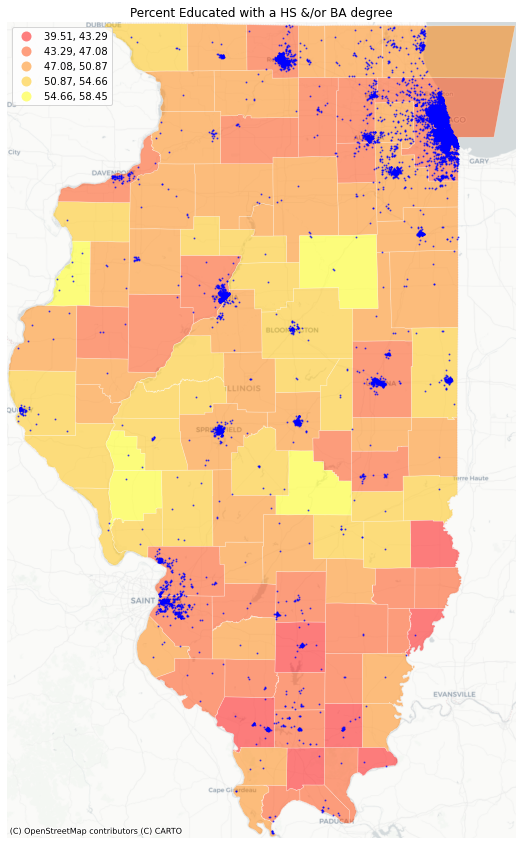

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))

illinoisEdu.plot(column='percent total educated', 
            cmap= 'autumn', 
            scheme='equal_interval',
            k=5, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=.5, 
            ax=ax,
            legend=True
           )

ax.axis('off')
ax.set_title("Percent Educated with a HS &/or BA degree")


gvIllinois .plot(ax=ax,
            color='blue',
            markersize=1,
            alpha=0.6)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The darker tracts on the map are a lower percentage of educated people and the bright/light yellow are tracts with a higher number of educated people. In this case we can see the clusters line up with mid or lower percentage of educated areas. However all the clusters are bordered by areas with higher percentages of education.

## Illinois Income VS Gun Violence Incidents
we will now compare the gun violence incidents as a scatterplot map to the chloropleth income map

we will start by dropping the first and second rows to remove outliers

In [19]:
illinoisInc = illinoisInc.drop([0])
illinoisInc = illinoisInc.drop([1])
illinoisInc.head()

,geoid,name,B19001001,"B19001001, Error",B19001002,"B19001002, Error",B19001003,"B19001003, Error",B19001004,"B19001004, Error",...,"B19001013, Error",B19001014,"B19001014, Error",B19001015,"B19001015, Error",B19001016,"B19001016, Error",B19001017,"B19001017, Error",geometry
2,05000US17001,"Adams County, IL",27112.0,358.0,1547.0,262.0,881.0,182.0,1692.0,263.0,...,326.0,2219.0,250.0,1203.0,210.0,1093.0,174.0,992.0,198.0,"MULTIPOLYGON (((-91.42411 39.93575, -91.42464 ..."
3,05000US17003,"Alexander County, IL",2154.0,161.0,240.0,70.0,169.0,63.0,149.0,53.0,...,60.0,52.0,31.0,44.0,27.0,56.0,36.0,9.0,11.0,"MULTIPOLYGON (((-89.19975 37.08887, -89.19963 ..."
4,05000US17005,"Bond County, IL",6299.0,360.0,467.0,145.0,277.0,116.0,358.0,133.0,...,176.0,634.0,144.0,306.0,85.0,280.0,85.0,207.0,81.0,"MULTIPOLYGON (((-89.36179 39.02772, -89.35987 ..."
5,05000US17007,"Boone County, IL",18571.0,424.0,703.0,234.0,621.0,187.0,531.0,162.0,...,292.0,1962.0,291.0,1441.0,316.0,1143.0,210.0,1356.0,258.0,"MULTIPOLYGON (((-88.94075 42.41387, -88.94074 ..."
6,05000US17009,"Brown County, IL",2055.0,162.0,86.0,31.0,142.0,48.0,84.0,49.0,...,67.0,249.0,68.0,107.0,49.0,94.0,55.0,45.0,34.0,"MULTIPOLYGON (((-90.91469 40.01804, -90.91469 ..."


Trim down the columns

In [20]:
list(illinoisInc)
columns_to_keep = ['geoid',
 'name',
 'B19001001',
 'B19001002',
 'B19001003',
 'B19001004',
 'B19001005',
 'B19001006',
 'B19001007',
 'B19001008',
'B19001009',
 'B19001010',
 'B19001011',
 'B19001012',
 'B19001013',
 'B19001014',
 'B19001015',
 'B19001016',
 'B19001017',
 'geometry']
illinoisInc = illinoisInc[columns_to_keep]

Rename the columns so they are usable and check to see if altered correctly

In [21]:
illinoisInc.columns = ['geoid',
 'name',
 'Total',
 'Less than $10,000',
 '10,000 to $14,999',
 '15,000 to $19,999',
 '20,000 to $24,999',
 '25,000 to $29,999',
 '30,000 to $34,999',
 '35,000 to $39,999',
 '40,000 to $44,999',
 '45,000 to $49,999',
 '50,000 to $59,999',
 '60,000 to $74,999',
 '75,000 to $99,999',
 '100,000 to $124,999',
 '$125,000 to $149,999',
 '150,000 to $199,999',
 '$200,000 or more',
 'geometry']
illinoisInc.head()

,geoid,name,Total,"Less than $10,000","10,000 to $14,999","15,000 to $19,999","20,000 to $24,999","25,000 to $29,999","30,000 to $34,999","35,000 to $39,999","40,000 to $44,999","45,000 to $49,999","50,000 to $59,999","60,000 to $74,999","75,000 to $99,999","100,000 to $124,999","$125,000 to $149,999","150,000 to $199,999","$200,000 or more",geometry
2,05000US17001,"Adams County, IL",27112.0,1547.0,881.0,1692.0,1276.0,1518.0,1511.0,1674.0,1331.0,1188.0,2446.0,2965.0,3576.0,2219.0,1203.0,1093.0,992.0,"MULTIPOLYGON (((-91.42411 39.93575, -91.42464 ..."
3,05000US17003,"Alexander County, IL",2154.0,240.0,169.0,149.0,182.0,166.0,119.0,131.0,142.0,94.0,255.0,144.0,202.0,52.0,44.0,56.0,9.0,"MULTIPOLYGON (((-89.19975 37.08887, -89.19963 ..."
4,05000US17005,"Bond County, IL",6299.0,467.0,277.0,358.0,298.0,232.0,178.0,279.0,262.0,332.0,579.0,569.0,1041.0,634.0,306.0,280.0,207.0,"MULTIPOLYGON (((-89.36179 39.02772, -89.35987 ..."
5,05000US17007,"Boone County, IL",18571.0,703.0,621.0,531.0,988.0,857.0,975.0,592.0,708.0,662.0,1505.0,2093.0,2434.0,1962.0,1441.0,1143.0,1356.0,"MULTIPOLYGON (((-88.94075 42.41387, -88.94074 ..."
6,05000US17009,"Brown County, IL",2055.0,86.0,142.0,84.0,135.0,82.0,47.0,96.0,89.0,47.0,150.0,286.0,316.0,249.0,107.0,94.0,45.0,"MULTIPOLYGON (((-90.91469 40.01804, -90.91469 ..."


Now I will normalize the raw data and add colums to my data that give %’s of each income level

In [22]:

illinoisInc['Percent Less than $10,000'] = illinoisInc['Less than $10,000']/illinoisInc['Total']*100
illinoisInc['Percent 10,000 to $14,999'] = illinoisInc['10,000 to $14,999']/illinoisInc['Total']*100
illinoisInc['Percent 15,000 to $19,999'] = illinoisInc['15,000 to $19,999']/illinoisInc['Total']*100
illinoisInc['Percent 20,000 to $24,999'] = illinoisInc['20,000 to $24,999']/illinoisInc['Total']*100 
illinoisInc['Percent 30,000 to $34,999'] = illinoisInc['30,000 to $34,999']/illinoisInc['Total']*100
illinoisInc['Percent 35,000 to $39,999'] = illinoisInc['35,000 to $39,999']/illinoisInc['Total']*100
illinoisInc['Percent 40,000 to $44,999'] = illinoisInc['40,000 to $44,999']/illinoisInc['Total']*100 
illinoisInc['Percent 45,000 to $49,999'] = illinoisInc['45,000 to $49,999']/illinoisInc['Total']*100
illinoisInc['Percent 50,000 to $59,999'] = illinoisInc['50,000 to $59,999']/illinoisInc['Total']*100
illinoisInc['Percent 60,000 to $74,999'] = illinoisInc['60,000 to $74,999']/illinoisInc['Total']*100
illinoisInc['Percent 75,000 to $99,999'] = illinoisInc['75,000 to $99,999']/illinoisInc['Total']*100 
illinoisInc['Percent 100,000 to $124,999'] = illinoisInc['100,000 to $124,999']/illinoisInc['Total']*100
illinoisInc['Percent $125,000 to $149,999'] = illinoisInc['$125,000 to $149,999']/illinoisInc['Total']*100 
illinoisInc['Percent 150,000 to $199,999'] = illinoisInc['150,000 to $199,999']/illinoisInc['Total']*100
illinoisInc['Percent $200,000 or more'] = illinoisInc['$200,000 or more']/illinoisInc['Total']*100 

show the census tract groups in illlinois using black lines

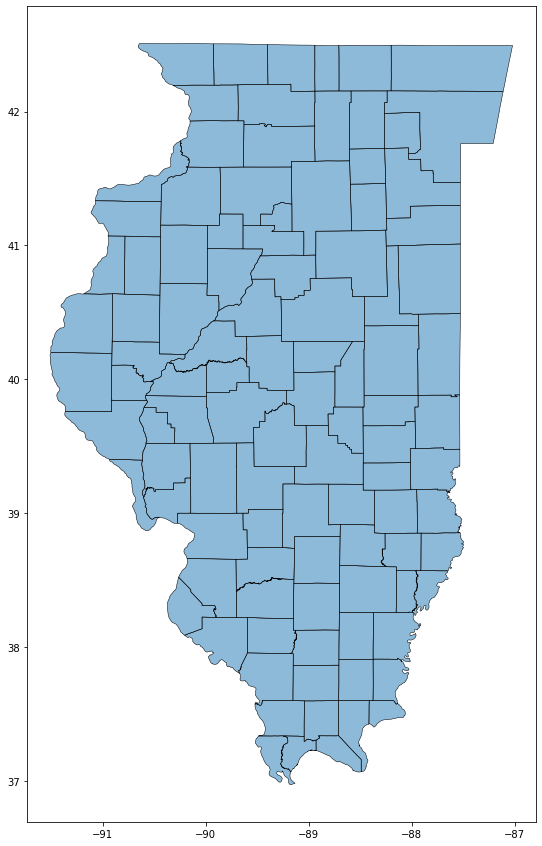

In [23]:
fig,ax = plt.subplots(figsize=(15,15))
illinoisInc.plot(ax=ax,zorder=10,alpha=.5)
illinoisInc.boundary.plot(ax=ax,color='black',zorder=15,lw=0.5)

we will now project the data onto a mercator map

In [24]:
illinoisInc = illinoisInc.to_crs(epsg=3857)

plot. turn off the axis, and add a base map

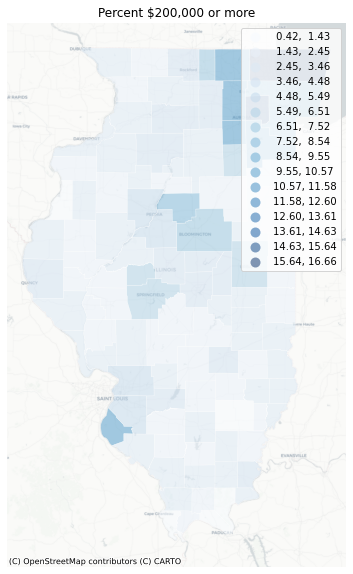

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))

illinoisInc.plot(column='Percent $200,000 or more', 
            cmap= 'Blues', 
            scheme='equal_interval',
            k=16, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.5, 
            ax=ax,
                 legend=True
           )
ax.axis('off')
ax.set_title("Percent $200,000 or more")

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

now we will add the bounds of Texas

In [26]:
minx, miny, maxx, maxy = illinoisInc.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-10187189.355204618
-9687014.853063764
4434967.519736574
5237454.393795698


now we set up a plot canvas using plt.subplots. we plot the illinois income census tract and texas gun violence data. we use the bounding box coodinates from earlier to set the x and y limits and add an agrument to create a margin around the total bounds. finally, no axis and add chloropleth basemap.

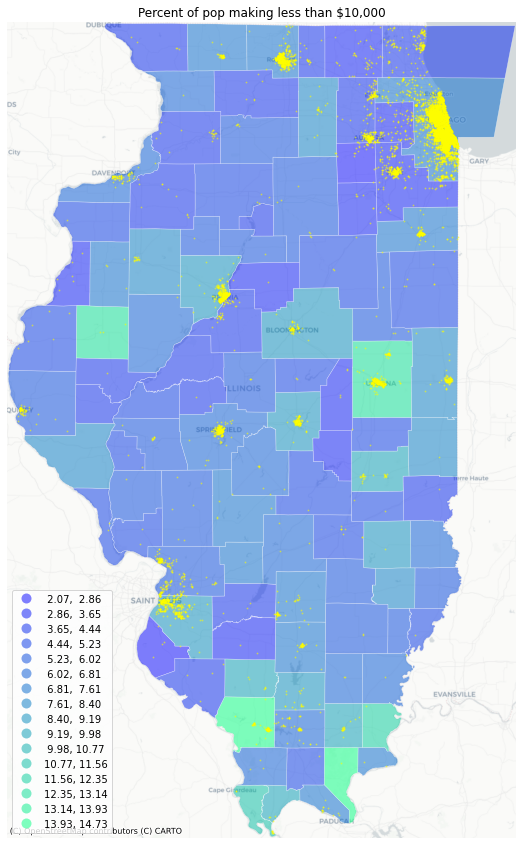

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))

illinoisInc.plot(column='Percent Less than $10,000', 
            cmap= 'winter', 
            scheme='equal_interval',
            k=16, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.5, 
            ax=ax,
            legend=True
           )
ax.axis('off')
ax.set_title("Percent of pop making less than $10,000")

gvIllinois.plot(ax=ax,
            color='yellow',
            markersize=1,
            alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In this case we mappeed the percent of population making an income of $10,000 or less, the tracts with a high percentage of people in that category are categorized but the bright teal. The dark blue areas are census tracts where there are a lower percentage of people making in that bracket so it is assumed that this is where people live with a higher income. We can see that the yellow clusters of gun violence incidents line up on the higher income areas.

To compare we also created a map that maps the census tract of people making $200,000 or more.

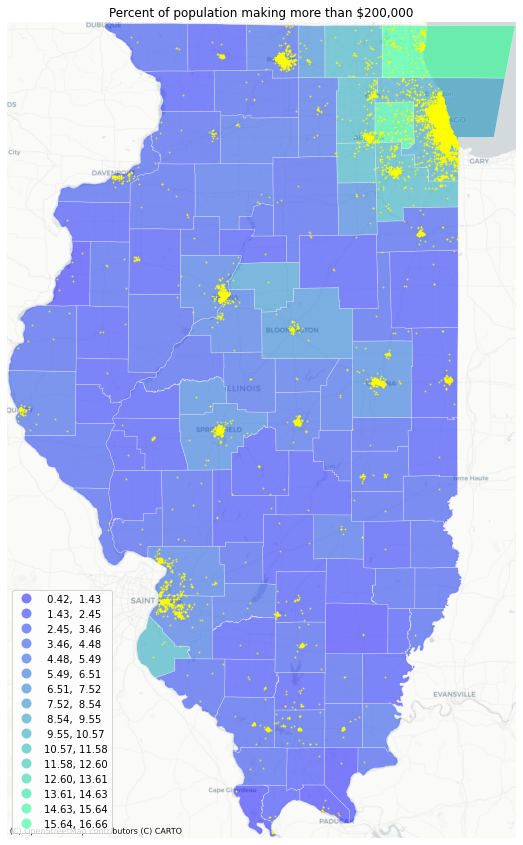

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))

illinoisInc.plot(column='Percent $200,000 or more', 
            cmap= 'winter', 
            scheme='equal_interval',
            k=16, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.5, 
            ax=ax,
            legend=True
           )

ax.axis('off')
ax.set_title("Percent of population making more than $200,000")
gvIllinois .plot(ax=ax,
            color='yellow',
            markersize=1,
            alpha=0.6)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

As we can see here our findings are the same as the one above. The clusters fall in higher income areas.

# Spatial Correlation

In [31]:
join = gpd.sjoin(gvIllinois , illinoisEdu, how='left')
join.head()

,latitude,longitude,geometry,index_right,geoid,name,Total,males with HS degree,males with BA degree,females with HS degree,females with BA degree,percent males with HS degree,percent males with BA degree,percent females with HS degree,percent females with BA degree,total educated,percent total educated
0,41.7592,-87.5628,POINT (-9747446.308 5124976.743),17.0,05000US17031,"Cook County, IL",3587576.0,411022.0,393243.0,418429.0,432430.0,11.456817,10.961245,11.663279,12.053543,1655124.0,46.134883
1,41.7358,-87.6631,POINT (-9758611.653 5121485.357),17.0,05000US17031,"Cook County, IL",3587576.0,411022.0,393243.0,418429.0,432430.0,11.456817,10.961245,11.663279,12.053543,1655124.0,46.134883
2,41.7906,-87.6418,POINT (-9756240.548 5129663.767),17.0,05000US17031,"Cook County, IL",3587576.0,411022.0,393243.0,418429.0,432430.0,11.456817,10.961245,11.663279,12.053543,1655124.0,46.134883
3,39.5417,-90.3301,POINT (-10055500.735 4799565.173),87.0,05000US17171,"Scott County, IL",3552.0,889.0,173.0,807.0,207.0,25.028153,4.870495,22.719595,5.827703,2076.0,58.445946
4,41.8968,-87.7556,POINT (-9768908.706 5145533.098),17.0,05000US17031,"Cook County, IL",3587576.0,411022.0,393243.0,418429.0,432430.0,11.456817,10.961245,11.663279,12.053543,1655124.0,46.134883


In [33]:
gvIllinois_by_illinoisEdu = join.geoid.value_counts().rename_axis('geoid').reset_index(name='gvIllinois_count')

In [35]:
gvIllinois_by_illinoisEdu.head()

,geoid,gvIllinois_count
0,05000US17031,11778
1,05000US17143,897
2,05000US17201,841
3,05000US17163,352
4,05000US17019,345


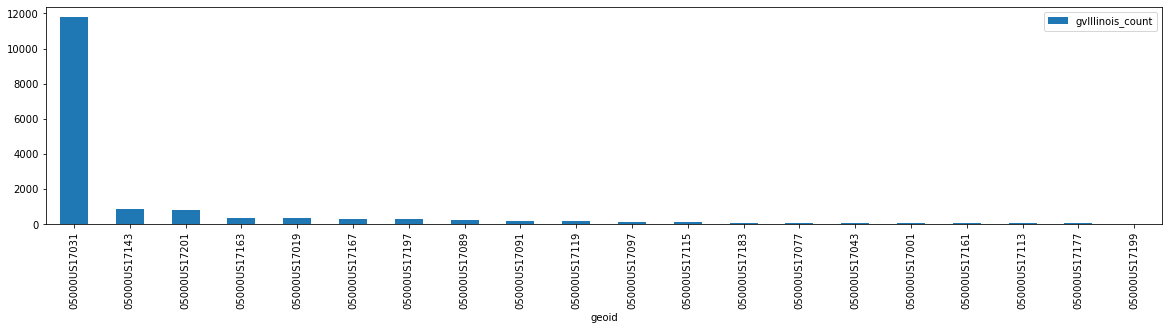

In [36]:
gvIllinois_by_illinoisEdu[:20].plot.bar(figsize=(20,4),
                             x='geoid',
                             y='gvIllinois_count')

In [37]:
illinoisEdu = illinoisEdu.merge(gvIllinois_by_illinoisEdu,on='geoid')

In [39]:
illinoisEdu['gvIllinois_per_1000'] = illinoisEdu['gvIllinois_count']/illinoisEdu['Total']*1000

In [40]:
illinoisEdu.sort_values(by="gvIllinois_per_1000").tail()

,geoid,name,Total,males with HS degree,males with BA degree,females with HS degree,females with BA degree,geometry,percent males with HS degree,percent males with BA degree,percent females with HS degree,percent females with BA degree,total educated,percent total educated,gvIllinois_count,gvIllinois_per_1000
40,05000US17091,"Kankakee County, IL",72882.0,12261.0,4541.0,12796.0,4858.0,"MULTIPOLYGON (((-9758801.564 5056222.064, -975...",16.823084,6.230619,17.557147,6.665569,34456.0,47.276419,200,2.744162
7,05000US17019,"Champaign County, IL",121964.0,14063.0,12395.0,12796.0,13768.0,"MULTIPOLYGON (((-9847675.484 4886627.381, -984...",11.530452,10.162835,10.491620,11.288577,53022.0,43.473484,345,2.828704
12,05000US17031,"Cook County, IL",3587576.0,411022.0,393243.0,418429.0,432430.0,"MULTIPOLYGON (((-9822629.934 5171018.759, -982...",11.456817,10.961245,11.663279,12.053543,1655124.0,46.134883,11778,3.282997
89,05000US17201,"Winnebago County, IL",193982.0,29947.0,13680.0,31621.0,14396.0,"MULTIPOLYGON (((-9951741.062 5217345.269, -995...",15.438030,7.052201,16.300997,7.421307,89644.0,46.212535,841,4.335454
63,05000US17143,"Peoria County, IL",122900.0,16080.0,10172.0,17854.0,12672.0,"MULTIPOLYGON (((-10017121.448 4982897.199, -10...",13.083808,8.276648,14.527258,10.310822,56778.0,46.198535,897,7.298617


In [41]:
wq = lps.weights.KNN.from_dataframe(illinoisEdu,k=8)
wq.transform = 'r'

In [42]:
illinoisEdu['gvIllinois_per_1000_lag'] = lps.weights.lag_spatial(wq, illinoisEdu['gvIllinois_per_1000'])

In [43]:
illinoisEdu['gvIllinois_lag_diff'] = illinoisEdu['gvIllinois_per_1000'] - illinoisEdu['gvIllinois_per_1000_lag']

In [44]:
illinoisEdu.sort_values(by='gvIllinois_lag_diff')

,geoid,name,Total,males with HS degree,males with BA degree,females with HS degree,females with BA degree,geometry,percent males with HS degree,percent males with BA degree,percent females with HS degree,percent females with BA degree,total educated,percent total educated,gvIllinois_count,gvIllinois_per_1000,gvIllinois_per_1000_lag,gvIllinois_lag_diff
23,05000US17057,"Fulton County, IL",25443.0,4852.0,1314.0,3927.0,1694.0,"MULTIPOLYGON (((-10068500.959 4944703.132, -10...",19.070078,5.164485,15.434501,6.658020,11787.0,46.327084,2,0.078607,1.300047,-1.221440
90,05000US17203,"Woodford County, IL",26058.0,4341.0,2991.0,3819.0,3076.0,"MULTIPOLYGON (((-9912746.624 5001395.819, -991...",16.658991,11.478241,14.655768,11.804436,14227.0,54.597436,2,0.076752,1.134410,-1.057658
55,05000US17123,"Marshall County, IL",8404.0,1673.0,549.0,1636.0,697.0,"MULTIPOLYGON (((-9925494.821 5027694.945, -992...",19.907187,6.532604,19.466921,8.293670,4555.0,54.200381,1,0.118991,1.128367,-1.009376
4,05000US17011,"Bureau County, IL",23582.0,4402.0,1553.0,4228.0,1752.0,"MULTIPOLYGON (((-10002825.799 5072833.198, -10...",18.666780,6.585531,17.928929,7.429395,11935.0,50.610635,4,0.169621,1.106716,-0.937095
31,05000US17073,"Henry County, IL",34574.0,6122.0,2719.0,5538.0,2817.0,"MULTIPOLYGON (((-10066896.400 5073632.793, -10...",17.706947,7.864291,16.017817,8.147741,17196.0,49.736796,10,0.289235,1.225974,-0.936740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,05000US17077,"Jackson County, IL",35042.0,4403.0,2431.0,4033.0,2977.0,"MULTIPOLYGON (((-9979769.084 4560906.363, -997...",12.564922,6.937389,11.509046,8.495520,13844.0,39.506877,95,2.711032,0.594395,2.116638
7,05000US17019,"Champaign County, IL",121964.0,14063.0,12395.0,12796.0,13768.0,"MULTIPOLYGON (((-9847675.484 4886627.381, -984...",11.530452,10.162835,10.491620,11.288577,53022.0,43.473484,345,2.828704,0.600788,2.227915
12,05000US17031,"Cook County, IL",3587576.0,411022.0,393243.0,418429.0,432430.0,"MULTIPOLYGON (((-9822629.934 5171018.759, -982...",11.456817,10.961245,11.663279,12.053543,1655124.0,46.134883,11778,3.282997,0.660514,2.622483
89,05000US17201,"Winnebago County, IL",193982.0,29947.0,13680.0,31621.0,14396.0,"MULTIPOLYGON (((-9951741.062 5217345.269, -995...",15.438030,7.052201,16.300997,7.421307,89644.0,46.212535,841,4.335454,0.499791,3.835663


In [45]:
y = illinoisEdu.gvIllinois_per_1000
moran = Moran(y, wq)
moran.I

-0.07161691794504647

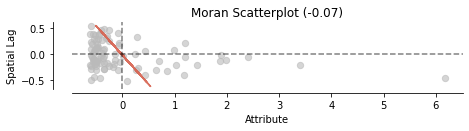

In [46]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [47]:
moran.p_sim

0.06